In [56]:
import torch
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from nn import FunctionModel, save_model, load_model
import copy
import matplotlib.pyplot as plt

In [120]:
ndim = 3
gamma = .5
kbt = .1
lam = 25
eta = 10
sigma = 3



# sample 
Nx_sample = 1000
Nv_sample = 1000
NA = 10
NB = 10
Nxb_sample=100
Nvb_sample=100

# 2048*16
# batch_size = 2048 #not implement

layers = [2*ndim,8,8,1]
activ  = 'sigmoid'

alpha_t = 1
T = 100
Nt = int(T/alpha_t)
Nsteps = 20
lr = 1e-3

device = torch.device(
                "cuda" if torch.cuda.is_available() else "cpu")



def loss_fn(outputs,data,res_q,res_dq,res_dqx):
    gradients = torch.autograd.grad(outputs=outputs, inputs=data,
                                        grad_outputs=torch.ones_like(outputs),
                                        create_graph=True, retain_graph=True)[0]
    grad_x = gradients[:,:ndim]
    grad_v = gradients[:,ndim:]
    '''
    loss = (kbt*torch.sum(grad_v**2)+torch.sum(outputs**2))/2 \
            +torch.sum(grad_v*res_dq)+torch.sum(outputs*res_q)
    '''
    #print(grad_v.shape,res_dq.shape)
    #print(outputs.shape,res_q.shape)
    if res_q.shape != (res_q.shape[0],1):
        res_q=res_q.unsqueeze(1)

    #print(grad_v.shape,res_dq.shape)
    #print(outputs.shape,res_q.shape)
    loss = (gamma*kbt*torch.sum(grad_v**2)+lam*torch.sum(outputs**2)+eta*torch.sum(grad_x**2))/2 \
            +torch.sum(grad_v*res_dq)+torch.sum(outputs*res_q)+torch.sum(grad_x*res_dqx)
            
    loss = loss / data.shape[0]

    return loss

def build_rightside(outputs,data,alpha_t,dU):
    with torch.no_grad():
        gradients = torch.autograd.grad(outputs=outputs, inputs=data,
                                            grad_outputs=torch.ones_like(outputs),
                                            create_graph=False, retain_graph=False)[0]
        grad_x = gradients[:,:ndim]
        grad_v = gradients[:,ndim:]

        '''
        res_q = -outputs-alpha_t*(data[:,ndim:]*grad_x-dU*grad_v)
        res_dq =-(1-gamma*alpha_t)*grad_v*kbt
        '''
        # print(outputs.shape,torch.sum((data[:,ndim:]*grad_x-dU*grad_v),dim=1,keepdim=True).shape)
        res_q = -lam*outputs-torch.sum((data[:,ndim:]*grad_x-dU*grad_v),dim=1,keepdim=True)
        res_dq = 0*grad_v
        res_dqx = -eta*grad_x

    return res_q, res_dq, res_dqx


x1 = (torch.rand(size=(Nx_sample,1),dtype=torch.float32))*2-1
print(x1)
xm1 = torch.randn(size=(Nx_sample,ndim-1),dtype=torch.float32)*sigma
x = torch.concatenate((x1,xm1),dim=1)
v = torch.randn(size=(Nv_sample,ndim),dtype = torch.float32)*np.sqrt(kbt)
data = torch.cat((x.repeat_interleave(Nv_sample,dim=0),v.repeat(Nx_sample,1)),dim=1)

def dU_func(x):
    dU = torch.zeros_like(x)
    dU[:,0] = 4*(x[:,0]**2-1)*x[:,0]
    dU[:,1:] = x[:,1:]/sigma**2
    return dU
dU = dU_func(data[:,:ndim])*1

vb = torch.randn(size=(Nvb_sample,ndim),dtype=torch.float32)*np.sqrt(kbt)
xA1 = torch.tensor([-1-0.1*i for i in range(NA)],dtype=torch.float32).unsqueeze_(-1)
xAm1 = torch.randn(size=(Nxb_sample,ndim-1),dtype=torch.float32)*sigma
xA = torch.cat((xA1.repeat_interleave(Nxb_sample,dim=0),xAm1.repeat(NA,1)),dim=1)
xA = torch.cat((xA.repeat_interleave(Nvb_sample,dim=0),vb.repeat(Nxb_sample*NA,1)),dim=1)

xB1 = torch.tensor([1+0.1*i for i in range(NB)],dtype=torch.float32).unsqueeze_(-1)
xBm1 = torch.randn(size=(Nxb_sample,ndim-1),dtype=torch.float32)*sigma
xB = torch.cat((xB1.repeat_interleave(Nxb_sample,dim=0),xBm1.repeat(NB,1)),dim=1)
xB = torch.cat((xB.repeat_interleave(Nvb_sample,dim=0),vb.repeat(NB*Nxb_sample,1)),dim=1)
labelA = 0*torch.ones_like(xA[:,0])
labelB = 1*torch.ones_like(xB[:,0])

data_b = torch.cat((xA,xB),dim=0)
label_b = torch.cat((labelA,labelB),dim=0).unsqueeze(dim=1)
print(label_b.shape)
del xA,xB,labelA,labelB

b_lossfn = torch.nn.MSELoss()

'''
res_q = -(data[:,0]+1)/2-alpha_t*data[:,0]/2
res_dq = torch.zeros_like(data[:,:ndim])
'''

q = FunctionModel(layer_sizes=layers,activation=activ)


    

tensor([[-7.7982e-01],
        [-3.3862e-01],
        [-5.4440e-01],
        [ 2.8063e-02],
        [ 6.5269e-01],
        [-8.0972e-01],
        [ 6.9205e-01],
        [ 4.8637e-01],
        [ 8.8203e-01],
        [-3.8178e-01],
        [-9.7889e-01],
        [ 4.8663e-01],
        [-7.7967e-01],
        [-4.6250e-02],
        [ 8.4977e-02],
        [-2.8707e-01],
        [ 8.0257e-01],
        [-2.8427e-01],
        [-8.8880e-01],
        [-7.2966e-01],
        [ 2.8149e-02],
        [ 7.1740e-02],
        [ 8.5301e-01],
        [ 2.1535e-01],
        [-7.4291e-01],
        [ 3.8423e-01],
        [ 5.9943e-01],
        [-2.7236e-01],
        [-2.7147e-01],
        [ 7.4987e-01],
        [-9.5282e-01],
        [-8.8572e-01],
        [-7.0494e-01],
        [-3.0901e-01],
        [-8.0817e-01],
        [-5.3246e-01],
        [ 3.0166e-01],
        [-7.1330e-01],
        [-3.0764e-02],
        [-8.0147e-02],
        [-8.0600e-01],
        [-8.2328e-01],
        [-9.8280e-01],
        [-6

In [110]:
def split(dataset,batchsize,shuffle=True):
    length = len(dataset[0])
    if shuffle:
        per = torch.randperm(length)
        for d in dataset:
            d = d[per]
    
    batches = []
    N = int(np.ceil(length/batchsize))
    for i in range(N): 
        batches.append((d[i*batchsize:min((i+1)*batchsize,length)] for d in dataset)) 
    return iter(batches)

In [111]:
def train_step(model,dataset,batchsize,data_b,label_b,alpha_b,opt,num_epoches,device,alpha_l2=1e-6,check_point = 10):
    loss_list,b_loss_list,tot_loss_list = [],[],[]
    for i in range(num_epoches):
        
        dataloader = split(dataset,batchsize,shuffle=True)
        for d,res_q,res_dq,res_dqx in dataloader:
            
            #torch.cuda.empty_cache()  
            #d=d.to(device)
            #rq=rq.to(device)
            #rdq=rdq.to(device)
            opt.zero_grad()
            y = model(d)
            y_b = model(data_b)
            
            loss = loss_fn(y,d,res_q,res_dq,res_dqx)
            b_loss = b_lossfn(y_b,label_b)
            l2_reg = 0
            for param in model.parameters():
                l2_reg += torch.norm(param) ** 2
            tot_loss = loss + b_loss*alpha_b+l2_reg*alpha_l2
            tot_loss.backward()
            opt.step()
            
        
        if i%check_point == 0:
            # print(i)
            #print(f"{i+1} epoches completed!")
            loss_list.append(loss.item())
            b_loss_list.append(b_loss.item())
            tot_loss_list.append(tot_loss.item())

    return loss_list,b_loss_list, tot_loss_list

def train(model,data:torch.Tensor,res_q,res_dq,res_dqx,batchsize,data_b,label_b,dU,alpha_b,lr,num_tsteps,num_epoches,device,checkpoint=10):
    torch.cuda.empty_cache()
    data = data.to(device)
    dU=dU.to(device)
    label_b = label_b.to(device)
    data_b = data_b.to(device)
    res_q = res_q.to(device)
    res_dq = res_dq.to(device)
    res_dqx = res_dqx.to(device)

    
    data.requires_grad_(True)
    loss_list,b_loss_list,tot_loss_list = [],[],[]
    for t in range(num_tsteps):
        print(f"itr{t}: Building dataset!")
        #dataset = TensorDataset(data.to('cpu'),res_q.to('cpu'),res_dq.to('cpu'))
        opt = optim.Adam(model.parameters(),lr=lr)
        # dataloader = (data,res_q,res_dq)
        print(f"itr{t}: Training!")
        ll,bl,tl=train_step(model,[data,res_q,res_dq,res_dqx],batchsize,data_b,label_b,alpha_b,opt,num_epoches,device,check_point=checkpoint)
        loss_list += ll
        b_loss_list += bl
        tot_loss_list += tl

        # torch.cuda.empty_cache()
        y = model(data)
        print(f"itr{t}: Training completed!")
        res_q,res_dq,res_dqx=build_rightside(y,data,alpha_t,dU)
        
        
    
    return loss_list,b_loss_list,tot_loss_list

In [112]:
data.requires_grad_(True)
q.to(device)
data = data.to(device)
y = q(data)
res_q,res_dq,res_dqx=build_rightside(y,data,alpha_t,dU.to(device))
batch_size = 2**22
loss_list,b_loss_list,tot_loss_list=train(model=q,
                                          data=data,
                                          res_q=res_q,
                                          res_dq=res_dq,
                                          res_dqx=res_dqx,
                                          batchsize=batch_size,
                                          data_b=data_b,
                                          label_b=label_b,
                                          alpha_b=100,
                                          lr = lr,
                                          num_tsteps=Nt,
                                          num_epoches=Nsteps,
                                          device=device,
                                          dU=dU,
                                          checkpoint=10)

itr0: Building dataset!
itr0: Training!
itr0: Training completed!
itr1: Building dataset!
itr1: Training!
itr1: Training completed!
itr2: Building dataset!
itr2: Training!
itr2: Training completed!
itr3: Building dataset!
itr3: Training!
itr3: Training completed!
itr4: Building dataset!
itr4: Training!
itr4: Training completed!
itr5: Building dataset!
itr5: Training!
itr5: Training completed!
itr6: Building dataset!
itr6: Training!
itr6: Training completed!
itr7: Building dataset!
itr7: Training!
itr7: Training completed!
itr8: Building dataset!
itr8: Training!
itr8: Training completed!
itr9: Building dataset!
itr9: Training!
itr9: Training completed!
itr10: Building dataset!
itr10: Training!
itr10: Training completed!
itr11: Building dataset!
itr11: Training!
itr11: Training completed!
itr12: Building dataset!
itr12: Training!
itr12: Training completed!
itr13: Building dataset!
itr13: Training!
itr13: Training completed!
itr14: Building dataset!
itr14: Training!
itr14: Training comple

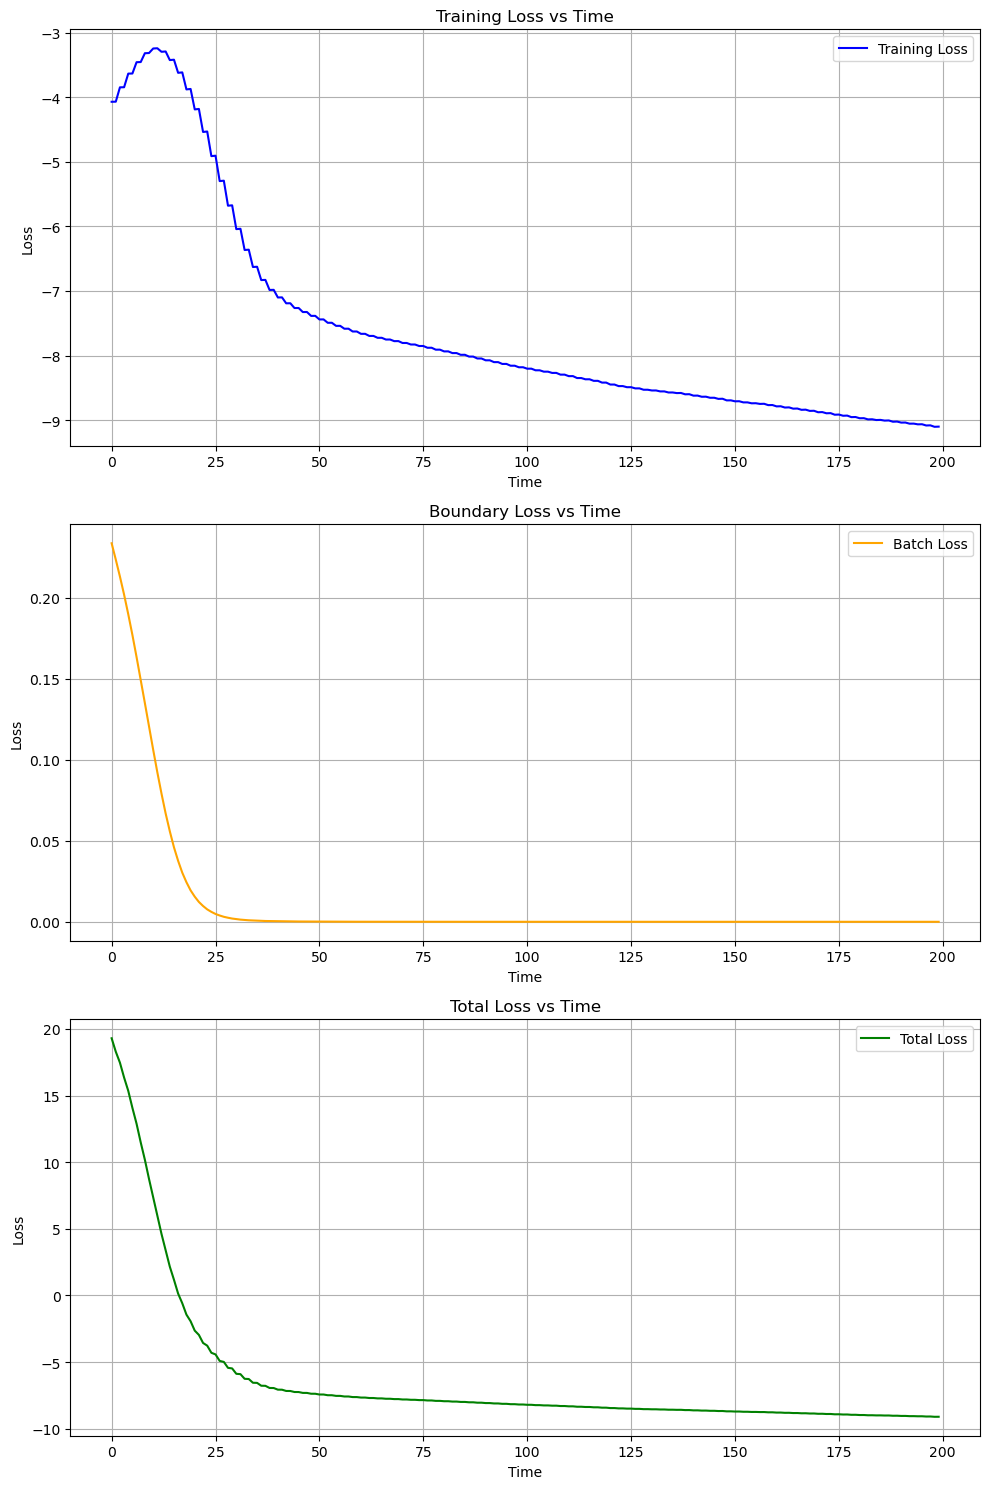

In [113]:
 # Length of the data  
t = np.arange(len(loss_list))  # Time values  


# Create a figure with 3 subplots  
fig, axs = plt.subplots(3, 1, figsize=(10, 15))  

# Plot training loss  
axs[0].plot(t, loss_list, label='Training Loss', color='blue')  
axs[0].set_title('Training Loss vs Time')  
axs[0].set_xlabel('Time')  
axs[0].set_ylabel('Loss')  
axs[0].legend()  
axs[0].grid()  

# Plot batch loss  
axs[1].plot(t, b_loss_list, label='Batch Loss', color='orange')  
axs[1].set_title('Boundary Loss vs Time')  
axs[1].set_xlabel('Time')  
axs[1].set_ylabel('Loss')  
axs[1].legend()  
axs[1].grid()  

# Plot total loss  
axs[2].plot(t, tot_loss_list, label='Total Loss', color='green')  
axs[2].set_title('Total Loss vs Time')  
axs[2].set_xlabel('Time')  
axs[2].set_ylabel('Loss')  
axs[2].legend()  
axs[2].grid()  

# Adjust layout  
plt.tight_layout()  
plt.show()  

In [114]:
#q=load_model('model/gamma0.5_kbt0.1_25I_3d.pth','config/gamma0.5_kbt0.1_25I_3d.txt')
#q =q.to(device)


In [115]:
xmin, xmax = -1, 1
vmin, vmax = -3*np.sqrt(kbt), 3*np.sqrt(kbt)
dx = 0.001
dv = 0.01*np.sqrt(kbt)
Nx = int((xmax - xmin) / dx)
Nv = int((vmax - vmin) / dv)
kbt = .1
gamma = .5

Ncol = Nx - 1
Nrow = Nv + 1
x = np.linspace(xmin, xmax, Nx + 1)
x=x.astype(np.float32)
v = np.linspace(vmin, vmax, Nv + 1)

if Ncol == Nx - 1:
    xcal = x[1:-1]
else:
    xcal = x

if Nrow == Nv - 1:
    vcal = v[1:-1]
else:
    vcal = v


X, V = np.meshgrid(xcal, vcal)
# print(X.shape, V)

points = np.array([X.reshape(-1), V.reshape(-1)]).T.astype(np.float32)
'''
c = np.arange(len(points))
plt.scatter(points[:, 0], points[:, 1], c=c)
plt.colorbar()
plt.show()
'''
N_matrix = Nrow * Ncol
ddd = torch.zeros((len(points),6),dtype=torch.float32)
ddd[:,[0,ndim]] = torch.from_numpy(points)


vvm1 = torch.randn(size=(1,ndim-1))*np.sqrt(kbt)
ddd[:,1:ndim] = vvm1
ddd = ddd.to(device)
qqq = q(ddd).squeeze().to('cpu').detach()





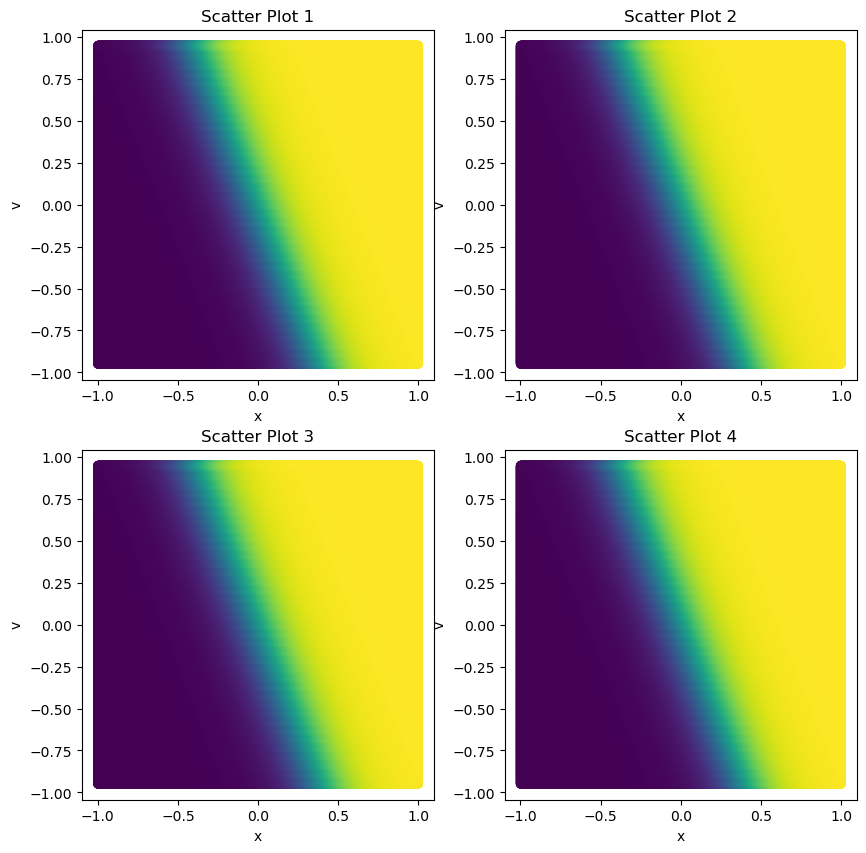

In [116]:
mm=2
nn=2
fig, axs = plt.subplots(mm, nn, figsize=(mm*5, nn*5))  

# Generate random data for each subplot  
for i in range(mm):  
    for j in range(nn):  
        vvm1 = torch.randn(size=(1,ndim-1),dtype = torch.float32).to(device)*np.sqrt(kbt)
        ddd[:,(ndim+1):] = vvm1
        xxm1 = torch.randn(size=(1,ndim-1),dtype = torch.float32).to(device)*sigma
        ddd[:,1:ndim] = xxm1
        qqq = q(ddd).squeeze().to('cpu').detach() 
        
        # Create scatter plot  
        axs[i, j].scatter(points[:,0],points[:,1],c=qqq)  
        axs[i, j].set_title(f'Scatter Plot {i*nn + j + 1}')  
        axs[i, j].set_xlabel('x')  
        axs[i, j].set_ylabel('v')

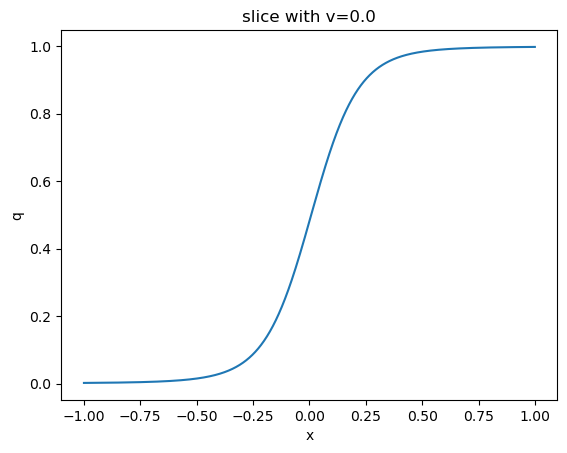

In [119]:
vslice = 0.0
Q = qqq.reshape(X.shape)
#Qfd = fd[:,2].reshape(X.shape)
#plt.plot(xcal, Q[int((vslice-vmin)/dv), :]-Qfd[int((vslice-vmin)/dv), :])
plt.plot(xcal, Q[int((vslice-vmin)/dv), :])
plt.xlabel('x')
plt.ylabel('q')
plt.title(f'slice with v={vslice}')
plt.show()

In [118]:
#model_file = f'./model/gamma{gamma}_kbt{kbt}_{lam}I_{ndim}d.pth'
#config_file = f'./config/gamma{gamma}_kbt{kbt}_{lam}I_{ndim}d.txt'
#save_model(q,model_file,config_file)